In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY,date2num,num2date,AutoDateLocator
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc,candlestick2_ochl,volume_overlay3

from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from featureapp import libs as ftlibs
from featureapp import models as ftmd
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import featureapp.models as ftmd
import featureapp.tasks as fttks
import queryapp.models as qrymd
import queryapp.tasks as qrytks

import charts.chartservers.libs as chservlibs
import charts.libs as chlibs

from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs


import featureapp as ftapp
import utility as uty
from utility import models as utymd
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
from talib.abstract import *
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng
from utility import maintenance as mnt
import os 
import json
from django.contrib.auth.models import AnonymousUser
import threading

stk=stkmd.Stockmeta.objects.get(Symbol='TSLA')
Fromdate=pd.datetime(2008,1,1)
Todate=pd.datetime.today()
Trange=pd.date_range(Fromdate,Todate)
Trange=[T.date() for T in Trange if T.weekday()<=4]

import json
# fttks.computefeatuers(stk.id,Trange)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Charting

In [ ]:
entries=[
    {'Symbol':'TSLA','TF':pd.datetime(2012,1,1).date(),'T0':pd.datetime(2011,1,1).date()  },
    {'Symbol':'AAPL','TF':pd.datetime(2012,1,1).date(),'T0':pd.datetime(2011,1,1).date()  }
]
chservlibs.request_db_charts(entries,5003)
# img=chlibs.CurrentByFutureChart_bydb(entries[0]['T0'],entries[0]['TF'],entries[0]['Symbol'],indicatorlist=(),pricecols=(),querycols=(),featcols=())


# Running Features

In [ ]:
print "---------------- features-------------------"
featurecodes=ftmd.FeatureComputeCode.objects.all()
computecode=featurecodes[0]
computeclass=computecode.importcomputeclass()
CF=computeclass(stk.id,Trange)
CF.computeall(skipdone=True)
# CF.saveall()
print CF.getfeaturelist()

CF.df=CF.addindicators(CF.df,[
        {'name':'SMAstd','timeperiod':20,'colname':'SMAstd20'},
        {'name':'EMAstd','timeperiod':8,'colname':'EMAstd8'},
    ])

# Running Queries

In [ ]:
querycodes=qrymd.QueryComputeCode.objects.all()
computecode=querycodes[0]
computeclass=computecode.importcomputeclass()
CQ=computeclass(stk.id,Trange)
CQ.computeall(skipdone=True)
CQ.saveall()

In [ ]:
CQ.OutcomeCharts()

In [ ]:
CQ.getquerylist()

In [ ]:
CQ.chartfeatures(addpricecols=(),ip=5562,
addfeatcols=[
    ['CCI5','CCI50'],
    ['PastPROFIT10days','PastLOSS10days'],['FutPROFIT10days','FutLOSS10days']
],
addquerycols=[
    'CCICHERRIES',
]
)

# Registering function

In [ ]:
from datascience import libs as dtsclibs
import pandas as pd

@dtsclibs.register_compfunc(RequiredImports=['import pandas as pd','from dataapp import libs as dtalibs'],overwrite_if_exists=False)
def extractdataset(data_id,Symbol):
    """
    @funcName : test
    @input x : an int
    @output df : pd.DataFrame, some random 2 by 2 
    @description : takes an int and then returns a dummy dataframe. This is just for testing purposes
    @Source : 
    def extractdataset(data_id,Symbol):
        window=60
        window_fut=30
        Tfs=map(lambda x: ( (x.date()-pd.Dateoffset(window)).date(),x.date(), (x.date()+pd.Dateoffset(window_fut)).date() ),
                pd.date_range(start=pd.datetime(2010,1,1),end=pd.datetime.today(),freq='W-MON') )

        N=len(Tfs)
        dfinstants=pd.DataFrame({'T0':map(lambda x: x[0],Tfs),'TF':map(lambda x: x[1],Tfs),'Symbol':[Symbol]*N})
        X,X_Meta=dtalibs.Getbatchdata(dfinstants)

        dfinstants=pd.DataFrame({'T0':map(lambda x: x[1],Tfs),'TF':map(lambda x: x[2],Tfs),'Symbol':[Symbol]*N})
        Y,Y_Meta=dtalibs.Getbatchdata(dfinstants)

        shard=dtscmd.DataShard(Data__id=data_id)
        shard.Info['X_Meta']=X_Meta
        shard.Info['Y_Meta']=Y_Meta
        shard.save()

        np.savez_compressed(shard.shardpath(),X=X,Y=Y)
    """
    
    window=60
    window_fut=30
    Tfs=map(lambda x: ( (x.date()-pd.Dateoffset(window)).date(),x.date(), (x.date()+pd.Dateoffset(window_fut)).date() ),
            pd.date_range(start=pd.datetime(2010,1,1),end=pd.datetime.today(),freq='W-MON') )
    
    N=len(Tfs)
    dfinstants=pd.DataFrame({'T0':map(lambda x: x[0],Tfs),'TF':map(lambda x: x[1],Tfs),'Symbol':[Symbol]*N})
    X,X_Meta=dtalibs.Getbatchdata(dfinstants)
    
    dfinstants=pd.DataFrame({'T0':map(lambda x: x[1],Tfs),'TF':map(lambda x: x[2],Tfs),'Symbol':[Symbol]*N})
    Y,Y_Meta=dtalibs.Getbatchdata(dfinstants)
    
    shard=dtscmd.DataShard(Data__id=data_id)
    shard.Info['X_Meta']=X_Meta
    shard.Info['Y_Meta']=Y_Meta
    shard.save()
    
    np.savez_compressed(shard.shardpath(),X=X,Y=Y)

extractdataset.id


# Creating initial Stock price dataset

In [1]:
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
projid,dataid=dtsclibs.register_dataset(project_Name="PredictReturn",project_Info={'description': "Data taken on every Monday. 360 days back and 60 days forward"},
                                        Datatype='RawProcessed',GroupName="AllStocks",tag="1",
                                        data_format='npz',Modeltype='Regression',
                                        TransformedFromDataId=None,TransFuncId=None, use_project_ifexists=True)

dtsctks.CreateStockData_2(360,60,dataid,None)

In [ ]:
print dtscmd.Data.objects.filter(Project__id=7,GroupName="AllStocks",tag="1",Datatype='RawProcessed',
                           Dataformat='npz',Modeltype='Regression')
data = dtscmd.Data.objects.get(Project__id=7,GroupName="AllStocks",tag="1",Datatype='RawProcessed',
                           Dataformat='npz',Modeltype='Regression')

data.datapath()

In [ ]:
dtscmd.DataShard.objects.filter(Data=data).delete()

In [ ]:
dtscmd.DataShard.objects.all()

# Functions on shards

In [25]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl


@dtsclibs.register_compfunc(Group='Cleanup',overwrite_if_exists=True)
def CleanData(shardId):
    """
    @Description: remove shards with many Nan samples. Remove samples with many Nans
    @Source
    import pandas as pd
    import numpy as np
    import datascience.models as dtscmd
    
    
    
    shard=dtscmd.DataShard.objects.get(id=shardId)
    X,Y,Meta=shard.getdata()
    
    # remove samples with lot of nans
    Nsamples=X.shape[0]
    Tsteps=X.shape[1]
    Nfeat=X.shape[2]
    volumecols=[4,11,12]
    colsX=list( Meta['MetaX']['columns'] )
    colsY=list( Meta['MetaY']['columns'] )
    delsample=[]
    for i in range(Nsamples):
        dfX=pd.DataFrame(X[i,:,:],columns=colsX)
        dfY=pd.DataFrame(X[i,:,:],columns=colsY)
        if np.sum(pd.isnull(dfX['Close'].values).astype(float))/len(dfX)>=0.5:
            delsample.append(i)
    
    X=np.delete(X,delsample,axis=0)
    Y=np.delete(Y,delsample,axis=0)
    
    # if not more samples then delete the shard
    if X.shape[0]/(Nsamples*1.0) <0.4:
        print "----------------------"
        print str(shardId)+"   "+ str(X.shape[0]/(Nsamples*1.0))
        print "----------------------"
        print "delete shaord id = "+str(shard.id)
        shard.delete()
    elif X.shape[0]!=Nsamples:
        shard.savedata(X=X,Y=Y,Meta=Meta)
    else:
        pass
    """
    
    import pandas as pd
    import numpy as np
    import datascience.models as dtscmd
    
    
    
    shard=dtscmd.DataShard.objects.get(id=shardId)
    X,Y,Meta=shard.getdata()
    
    # remove samples with lot of nans
    Nsamples=X.shape[0]
    Tsteps=X.shape[1]
    Nfeat=X.shape[2]
    volumecols=[4,11,12]
    colsX=list( Meta['MetaX']['columns'] )
    colsY=list( Meta['MetaY']['columns'] )
    delsample=[]
    for i in range(Nsamples):
        dfX=pd.DataFrame(X[i,:,:],columns=colsX)
        dfY=pd.DataFrame(X[i,:,:],columns=colsY)
        if np.sum(pd.isnull(dfX['Close'].values).astype(float))/len(dfX)>=0.5:
            delsample.append(i)
    
    X=np.delete(X,delsample,axis=0)
    Y=np.delete(Y,delsample,axis=0)
    
    # if not more samples then delete the shard
    if X.shape[0]/(Nsamples*1.0) <0.4:
        print "----------------------"
        print str(shardId)+"   "+ str(X.shape[0]/(Nsamples*1.0))
        print "----------------------"
        print "delete shaord id = "+str(shard.id)
        shard.delete()
    elif X.shape[0]!=Nsamples:
        shard.savedata(X=X,Y=Y,Meta=Meta)
    else:
        pass
    
# dtsctks.applyfunc2data(CleanData.id,6)


over writing previous function
saving function :  CleanData
function id =  20


In [26]:
dtscmd.DataShard.objects.filter(Data__id=6).count()

6548

# Creating derived DataSet

In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl

@dtsclibs.register_compfunc(Group='Transformer',overwrite_if_exists=True)
def StandardizeData_1(X,Y,Meta):
    import pandas as pd
    import numpy as np
    
    """
    A transformer function has to take X,Y,Meta and return another modified X,Y,Meta
    1. Normalize all data as 
        1. Volume to 0-1
        2. Prices --> also 0-1
    2. For output Y data:
        1. Take only Close
        2. Pull out best returns in first 5 days, 10 days, 30 days, 60 days, 90 days
        3. Pull out worst loss in first 5 days, 10 days, 30 days, 60 days, 90 days
    
    @Source:
    # next normalize the volume to 0-1
    Nsamples=X.shape[0]
    Tsteps=X.shape[1]
    Nfeat=X.shape[2]
    volumecols=['Volume','VolSMA10','VolSMA20']
    pricecols=['Close','Open','High','Low','SMA10','SMA20','SMA50','SMA100','SMA200','EMA8','EMA20']
    colsX=list( Meta['MetaX']['columns'] )
    colsY=list( Meta['MetaY']['columns'] )
    FinalXcols=pricecols+volumecols
    FinalYcols=['FutProfit5days','FutProfit10days','FutProfit30days','FutProfit60days','FutProfit90days']+['FutLoss5days',
                                    'FutLoss10days','FutLoss30days','FutLoss60days','FutLoss90days']
    
    Xn=None
    Yn=None
    Metan=None
    for i in range(Nsamples):
        dfX=pd.DataFrame(X[i,:,:],columns=colsX)
        dfY=pd.DataFrame(Y[i,:,:],columns=colsY)
        
        
        # clean up Y
        dfY.drop('Symbol',axis=1,inplace=True)
        
        dfY.drop(volumecols,axis=1,inplace=True)
        dfY.drop([cc for cc in pricecols if cc!='Close'],axis=1,inplace=True)
        
        Ydict={}
        dfY['ZeroPerf']=0
    
#         dfY['FutProfit5days']=-100*self.df['Close'].diff(periods=-5)/self.df['Close']
        dfY['Returns']=100*(dfY['Close']-dfY['Close'].iloc[0])/dfY['Close'].iloc[0]
        
        Ydict['FutProfit5days']=dfY[['Returns','ZeroPerf']].iloc[0:5].max(axis=1).round().max()
        Ydict['FutProfit10days']=dfY[['Returns','ZeroPerf']].iloc[0:10].max(axis=1).round().max()
        Ydict['FutProfit30days']=dfY[['Returns','ZeroPerf']].iloc[0:30].max(axis=1).round().max()
        Ydict['FutProfit60days']=dfY[['Returns','ZeroPerf']].iloc[0:60].max(axis=1).round().max()
        Ydict['FutProfit90days']=dfY[['Returns','ZeroPerf']].iloc[0:90].max(axis=1).round().max()
        
        Ydict['FutLoss5days']=dfY[['Returns','ZeroPerf']].iloc[0:5].min(axis=1).round().min()
        Ydict['FutLoss10days']=dfY[['Returns','ZeroPerf']].iloc[0:10].min(axis=1).round().min()
        Ydict['FutLoss30days']=dfY[['Returns','ZeroPerf']].iloc[0:30].min(axis=1).round().min()
        Ydict['FutLoss60days']=dfY[['Returns','ZeroPerf']].iloc[0:60].min(axis=1).round().min()
        Ydict['FutLoss90days']=dfY[['Returns','ZeroPerf']].iloc[0:90].min(axis=1).round().min()
        
        # clean up X
        dfX.drop('Symbol',axis=1,inplace=True)
        
        mxvol=dfX['Volume'].max()
        dfX['Volume']=dfX['Volume']/mxvol
        dfX['VolSMA10']=dfX['VolSMA10']/mxvol
        dfX['VolSMA20']=dfX['VolSMA20']/mxvol
        
        mxHigh=dfX['High'].max()
        mnLow=dfX['Low'].min()
        for cc in pricecols:
            dfX[cc]=(dfX[cc]-mnLow)/mxHigh
        
        XX=np.expand_dims( dfX[FinalXcols].astype(float).values   ,axis=0     )
        YY=np.expand_dims( np.array([int(Ydict[key]) for key in FinalYcols]),axis=0 )
        if Xn is None:
            Xn=XX
            Yn=YY
        else:
            Xn=np.vstack((Xn,XX))
            Yn=np.vstack((Yn,YY))
    
    Metan=Meta
    Metan['MetaX']['columns']=FinalXcols
    Metan['MetaY']['columns']=FinalYcols
    
    return Xn,Yn,Metan

    """
    
    # next normalize the volume to 0-1
    Nsamples=X.shape[0]
    Tsteps=X.shape[1]
    Nfeat=X.shape[2]
    volumecols=['Volume','VolSMA10','VolSMA20']
    pricecols=['Close','Open','High','Low','SMA10','SMA20','SMA50','SMA100','SMA200','EMA8','EMA20']
    colsX=list( Meta['MetaX']['columns'] )
    colsY=list( Meta['MetaY']['columns'] )
    FinalXcols=pricecols+volumecols
    FinalYcols=['FutProfit5days','FutProfit10days','FutProfit30days','FutProfit60days','FutProfit90days']+['FutLoss5days',
                                    'FutLoss10days','FutLoss30days','FutLoss60days','FutLoss90days']
    
    Xn=None
    Yn=None
    Metan=None
    for i in range(Nsamples):
        dfX=pd.DataFrame(X[i,:,:],columns=colsX)
        dfY=pd.DataFrame(Y[i,:,:],columns=colsY)
        
        
        # clean up Y
        dfY.drop('Symbol',axis=1,inplace=True)
        
        dfY.drop(volumecols,axis=1,inplace=True)
        dfY.drop([cc for cc in pricecols if cc!='Close'],axis=1,inplace=True)
        
        Ydict={}
        dfY['ZeroPerf']=0
    
#         dfY['FutProfit5days']=-100*self.df['Close'].diff(periods=-5)/self.df['Close']
        dfY['Returns']=100*(dfY['Close']-dfY['Close'].iloc[0])/dfY['Close'].iloc[0]
        
        Ydict['FutProfit5days']=dfY[['Returns','ZeroPerf']].iloc[0:5].max(axis=1).round().max()
        Ydict['FutProfit10days']=dfY[['Returns','ZeroPerf']].iloc[0:10].max(axis=1).round().max()
        Ydict['FutProfit30days']=dfY[['Returns','ZeroPerf']].iloc[0:30].max(axis=1).round().max()
        Ydict['FutProfit60days']=dfY[['Returns','ZeroPerf']].iloc[0:60].max(axis=1).round().max()
        Ydict['FutProfit90days']=dfY[['Returns','ZeroPerf']].iloc[0:90].max(axis=1).round().max()
        
        Ydict['FutLoss5days']=dfY[['Returns','ZeroPerf']].iloc[0:5].min(axis=1).round().min()
        Ydict['FutLoss10days']=dfY[['Returns','ZeroPerf']].iloc[0:10].min(axis=1).round().min()
        Ydict['FutLoss30days']=dfY[['Returns','ZeroPerf']].iloc[0:30].min(axis=1).round().min()
        Ydict['FutLoss60days']=dfY[['Returns','ZeroPerf']].iloc[0:60].min(axis=1).round().min()
        Ydict['FutLoss90days']=dfY[['Returns','ZeroPerf']].iloc[0:90].min(axis=1).round().min()
        
        # clean up X
        dfX.drop('Symbol',axis=1,inplace=True)
        
        mxvol=dfX['Volume'].max()
        dfX['Volume']=dfX['Volume']/mxvol
        dfX['VolSMA10']=dfX['VolSMA10']/mxvol
        dfX['VolSMA20']=dfX['VolSMA20']/mxvol
        
        mxHigh=dfX['High'].max()
        mnLow=dfX['Low'].min()
        for cc in pricecols:
            dfX[cc]=(dfX[cc]-mnLow)/mxHigh
        
        XX=np.expand_dims( dfX[FinalXcols].astype(float).values   ,axis=0     )
        YY=np.expand_dims( np.array([int(Ydict[key]) for key in FinalYcols]),axis=0 )
        if Xn is None:
            Xn=XX
            Yn=YY
        else:
            Xn=np.vstack((Xn,XX))
            Yn=np.vstack((Yn,YY))
    
    Metan=Meta
    Metan['MetaX']['columns']=FinalXcols
    Metan['MetaY']['columns']=FinalYcols
    
    return Xn,Yn,Metan


projectid,dataid=dtsclibs.register_dataset(tag='NormalizedDerivedFromId6',TransformedFromDataId=6,TransFuncId=StandardizeData_1.id )

dtsctks.Perform_TransformData(dataid)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  StandardizeData_1
function id =  21
Project  PredictReturn  already exists
The dataset already exists
saving transfoermer function to this dataset
('project id', 'data id')  :  (7, 9)


In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import dataapp.stockdata_transformers as stktrfrmr

funcid=stktrfrmr.StandardizeData_Close01Volume01_X30_Y5.id
DataInfo={'description':'All stocks data, close price is made into 0-1, Volume is made into 0-1, Y is profit/(profit+loss) for next 5 days'}
projectid,dataid=dtsclibs.register_dataset(GroupName='AllStocksCloseVol',DataInfo=DataInfo,tag='NormalizedDerived30days_5daysFromId6',TransformedFromDataId=6,TransFuncId=funcid )

dtsctks.Perform_TransformData(dataid)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5
function id =  25
Project  PredictReturn  already exists
The dataset already exists
updating data info
saving transfoermer function to this dataset
('project id', 'data id')  :  (7, 10)


In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

funcid=stktrfrmr.StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout.id
DataInfo={'description':'FLATTENED!!!  All stocks data, close price is made into 0-1, Volume is made into 0-1, Y is profit/(profit+loss) for next 5 days'}
projectid,dataid=dtsclibs.register_dataset(GroupName='AllStocksCloseVol_FLATTENED',DataInfo=DataInfo,tag='NormalizedDerived30days_5daysFromId6',TransformedFromDataId=6,TransFuncId=funcid,DeleteShards=True )

dtsctks.Perform_TransformData(dataid)



Project  PredictReturn  already exists
The dataset already exists
updating data info
Deleting the existing shards for this data
saving transfoermer function to this dataset
('project id', 'data id')  :  (7, 42)


In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl

data=dtscmd.Data.objects.get(id=43)
X,Y,Meta=data.getdata()

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X.shape

(1546208, 60)

# Get Shard Meta

In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

funcId=stktrfrmr.DataShardMeta_1.id
dataId=42
M=dtsctks.applyfunc2data(funcId,dataId,wait=True)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  DataShardMeta_1
function id =  29
over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned
function id =  27
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout
function id =  28


In [ ]:
M.values()[:10]

In [4]:
reduce(lambda x,y:[x[0]+y[0],x[1]+y[1],x[2]+y[2][0],x[3]+y[3][0]],M.values(),[0,0,0,0]) 

[0, 0, 2315765, 2315765]

# Get Overview of Projects and data

In [5]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.stockdata_transformers as stktrfrmr


    
print "------------ Data ----------------------"
for proj in dtscmd.Project.objects.all():
    print "Project  :: ","ProjectName=",proj.Name," ProjectId",proj.id
    for data in dtscmd.Data.objects.filter(Project=proj).order_by("id"): #
        print "\t","id=",data.id," ParentId=",data.ParentData.id if data.ParentData is not None else None 
        print "\t","GroupName=",data.GroupName," tag=",data.tag
        print "\t","Modeltype=",data.Modeltype," DataStructure=",data.DataStructure
        print "\t","Datatype=",data.Datatype," Dataformat=",data.Dataformat
        print "\t","#shards=",dtscmd.DataShard.objects.filter(Data=data).count()
        print "\t ------------------"
        

------------ Data ----------------------
Project  ::  ProjectName= PredictReturn  ProjectId 7
	id= 6  ParentId= None
	GroupName= AllStocks  tag= 1
	Modeltype= Regression  DataStructure= Channels
	Datatype= RawProcessed  Dataformat= npz
	#shards= 6548
	 ------------------
	id= 42  ParentId= 6
	GroupName= AllStocksCloseVol_FLATTENED  tag= NormalizedDerived30days_5daysFromId6
	Modeltype= Regression  DataStructure= Channels
	Datatype= RawProcessed  Dataformat= npz
	#shards= 6540
	 ------------------
	id= 43  ParentId= 42
	GroupName= AllStocksCloseVol_FLATTENED  tag= NormalizedDerived30days_5daysFromId6_train_0
	Modeltype= Regression  DataStructure= Channels
	Datatype= Train  Dataformat= npz
	#shards= 6540
	 ------------------
	id= 44  ParentId= 42
	GroupName= AllStocksCloseVol_FLATTENED  tag= NormalizedDerived30days_5daysFromId6_valid_0
	Modeltype= Regression  DataStructure= Channels
	Datatype= Validation  Dataformat= npz
	#shards= 6540
	 ------------------
	id= 45  ParentId= 42
	GroupName

# Create Train and Valid

In [4]:
import datascience.ML.MLlibs as MLlibs
MLlibs.get_train_test_from_RawProcessed(42)

Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 43)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 44)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 45)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 46)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 47)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 48)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 49)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 50)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 51)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 52)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 53)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 54)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 55)

# Generate Models 

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from __future__ import division
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().delete()

[Errno 2] No such file or directory: '/home/venkat/GoogleDrive/repos/trade_analytics/trade_analytics/bigdata/datascience/Projects/PredictReturn/Models/3_RandomForrest.joblib'


(1, {u'datascience.MLmodels': 1, u'datascience.ModelMetrics': 0})

In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=43)
M=MLmod.RandomForrrest_1()
M.GenModels(proj,traindata)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
M.filename

'AnonymousUser'

In [ ]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

model=dtscmd.MLmodels.objects.get(id=4)
M=MLmod.RandomForrrest_1()
M.loadmodel(model)
M.loaddata()
X,Y=M.pre_processing_train()
M.train()
M.Run_validation_all()

In [15]:
from datascience import models as dtscmd
L=list( dtscmd.MLmodels.objects.filter(Status='Trained').order_by('updated_at').values_list('updated_at',flat=True) )
print len(L)
print L

99
[datetime.datetime(2017, 8, 5, 3, 8, 53, 385307, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 14, 57, 362102, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 15, 7, 895384, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 15, 40, 161373, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 17, 52, 980785, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 18, 16, 905062, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 21, 25, 847438, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 21, 43, 196454, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 28, 17, 268610, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 28, 17, 532066, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 33, 35, 692168, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 33, 38, 719785, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 35, 22, 709903, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 35, 23, 430871, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 38, 35, 981373, tzinfo=<UTC>), datetime.datetime(2017, 8, 5, 3, 38, 3

In [8]:
from datascience import models as dtscmd
dtscmd.MLmodels.objects.filter(Status='Trained').count()


8

In [10]:
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().delete()

(320, {u'datascience.MLmodels': 320, u'datascience.ModelMetrics': 0})

In [5]:
from __future__ import division
from datascience import models as dtscmd

SS=dtscmd.ModelCode.objects.all()[0]
SS.Username='AnonymousUser'
SS.save()

# print dtscmd.ModelCode.objects.all()[0].Code

In [10]:
from __future__ import division
from datascience import models as dtscmd

modelid=1604
model=dtscmd.MLmodels.objects.get(id=modelid)
MCode=dtscmd.ModelCode.objects.get(Username=model.Userfilename)
Mclass=MCode.importobject(model.Name)
M=Mclass()
M.loadmodel(model)
M.loaddata()
M.train()

datascience/ML/MLmodels.py:175: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.clf.fit(X,Y)


In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs

dtsctks.TrainProject(7)


In [4]:
list(dtscmd.ModelMetrics.objects.all().values_list('Metrics',flat=True))

[{u'acc': 0.5873301132989499,
  u'avgprec': 0.7500245475466635,
  u'logloss': 14.253347959156393,
  u'precisionscore': 0.5873301132989499,
  u'recallscore': 0.5873301132989499},
 {u'acc': 0.5778389385061795,
  u'avgprec': 0.7391744823896076,
  u'logloss': 14.58117097308135,
  u'precisionscore': 0.5778389385061795,
  u'recallscore': 0.5778389385061795},
 {u'acc': 0.5755662023735734,
  u'avgprec': 0.7360772170628063,
  u'logloss': 14.659673633086008,
  u'precisionscore': 0.5755662023735734,
  u'recallscore': 0.5755662023735734},
 {u'acc': 0.5804014517443152,
  u'avgprec': 0.7419373765432435,
  u'logloss': 14.492664477413697,
  u'precisionscore': 0.5804014517443152,
  u'recallscore': 0.5804014517443152},
 {u'acc': 0.5781638007321095,
  u'avgprec': 0.7417555815507899,
  u'logloss': 14.569947829098775,
  u'precisionscore': 0.5781638007321095,
  u'recallscore': 0.5781638007321095},
 {u'acc': 0.5707517441852911,
  u'avgprec': 0.7286107886195881,
  u'logloss': 14.825961350411745,
  u'precision

In [10]:
np.round(Y)

array([[ 1.],
       [ 1.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]])

In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=43)
X,Y,Meta=traindata.getdata()

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
from datascience.ML.MLmodels import *

In [ ]:
import numpy as np
Y1=np.round(Y)
Y1=keras.utils.np_utils.to_categorical(Y1)

N=0
batch_size = 5000
nb_epoch = 25
random_state = 51

input_dim=X.shape[1]

model = Sequential()
model.add(Dense(output_dim=25, input_dim=input_dim,kernel_regularizer=regularizers.l2(0.1),))
model.add(Activation("sigmoid"))
model.add(Dropout(0.1))

# model.add(Dense(output_dim=25, input_dim=input_dim,kernel_regularizer=regularizers.l2(0.1),))
# model.add(Activation("sigmoid"))
# model.add(Dropout(0.1))


model.add(Dense(output_dim=2))
model.add(Activation("softmax"))

optm = SGD(lr=1e-2, decay=1e-6, momentum=0.5, nesterov=True)
# optm=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X,Y1, batch_size=batch_size, epochs=nb_epoch, verbose=1, callbacks=None, validation_split=0.3, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=25, kernel_regularizer=<keras.reg..., input_dim=60)`
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=2)`


Train on 1082345 samples, validate on 463863 samples
Epoch 1/25
1082345/1082345 [==============================] - 4s - loss: 2.3810 - acc: 0.5136 - val_loss: 1.3075 - val_acc: 0.5238
Epoch 2/25
1082345/1082345 [==============================] - 3s - loss: 0.9950 - acc: 0.5193 - val_loss: 0.7999 - val_acc: 0.5231
Epoch 3/25
1082345/1082345 [==============================] - 3s - loss: 0.7520 - acc: 0.5210 - val_loss: 0.7112 - val_acc: 0.5231
Epoch 4/25
1082345/1082345 [==============================] - 3s - loss: 0.7084 - acc: 0.5228 - val_loss: 0.6957 - val_acc: 0.5231
Epoch 5/25
1082345/1082345 [==============================] - 3s - loss: 0.7000 - acc: 0.5237 - val_loss: 0.6933 - val_acc: 0.5231
Epoch 6/25
1082345/1082345 [==============================] - 3s - loss: 0.6980 - acc: 0.5238 - val_loss: 0.6925 - val_acc: 0.5231
Epoch 7/25
1082345/1082345 [==============================] - 3s - loss: 0.6968 - acc: 0.5238 - val_loss: 0.6925 - val_acc: 0.5231
Epoch 8/25
1082345/1082345 [==

In [67]:
import keras
Y1=np.round(Y/0.5)
Y2=keras.utils.np_utils.to_categorical(Y1)
Y2.shape

(1546208, 3)

In [72]:
Y1[Y1[:,0]==1,:]

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [56]:
print len(Y1[Y1==0]),len(Y1[Y1==0.5]),len(Y1[Y1==1])

561483 222717 762008


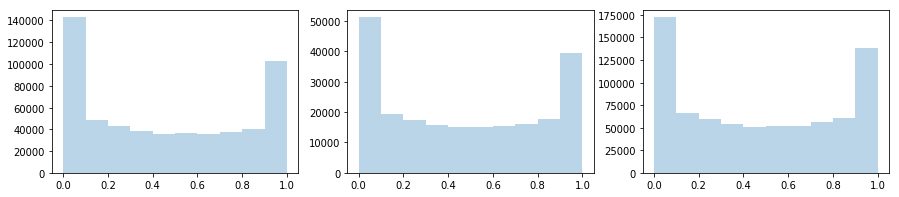

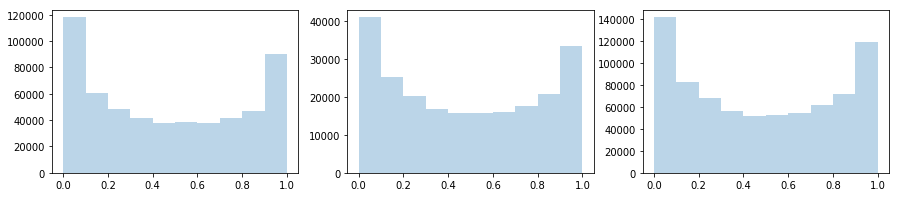

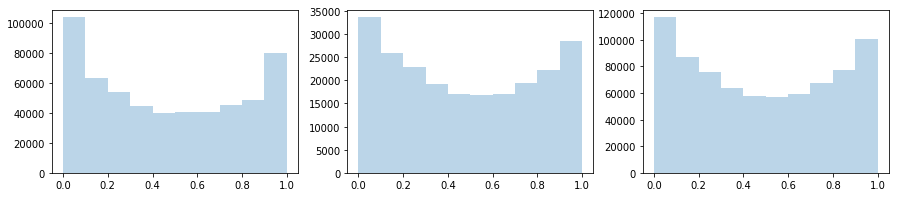

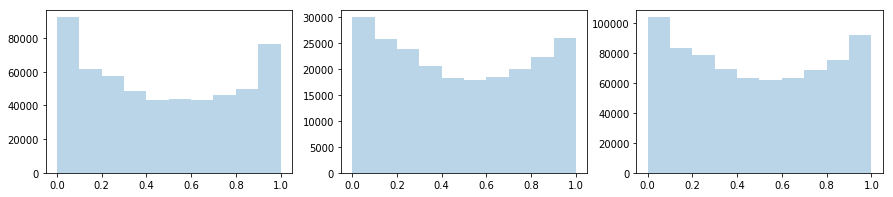

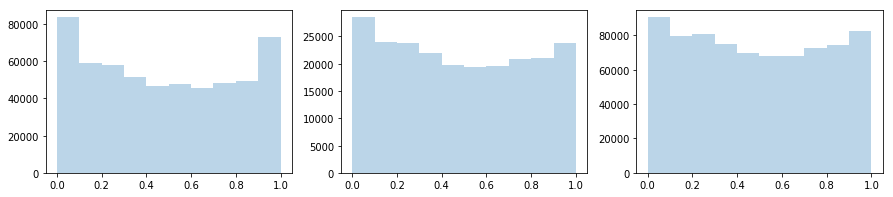

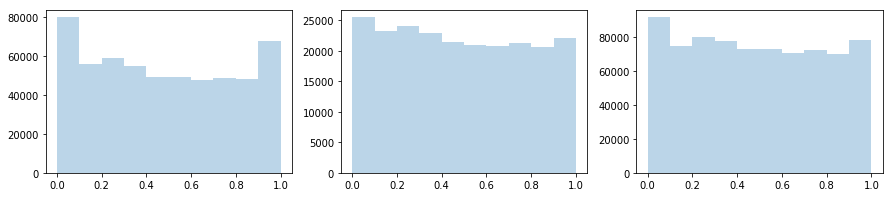

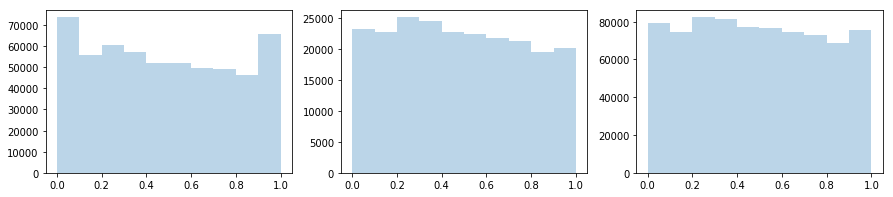

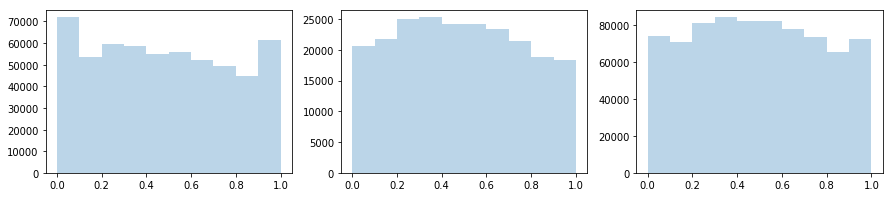

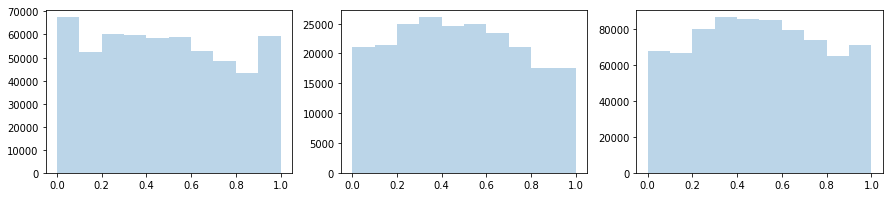

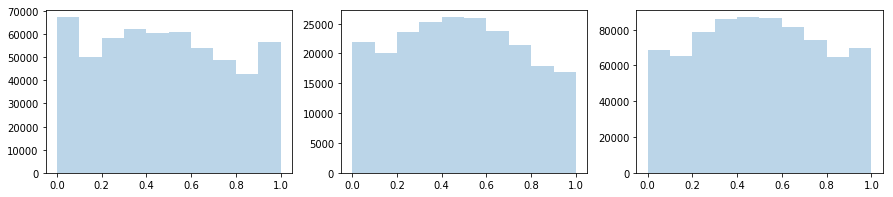

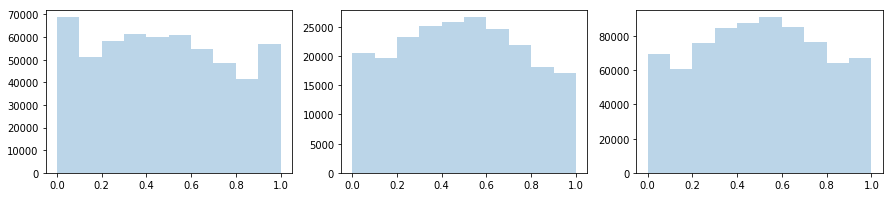

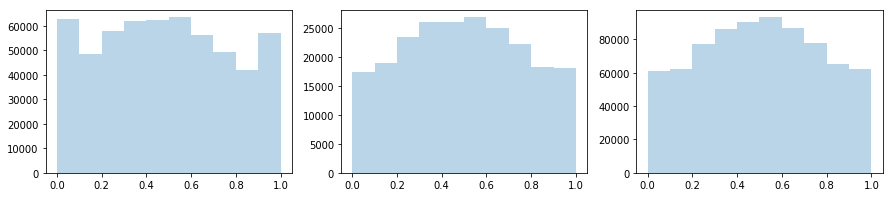

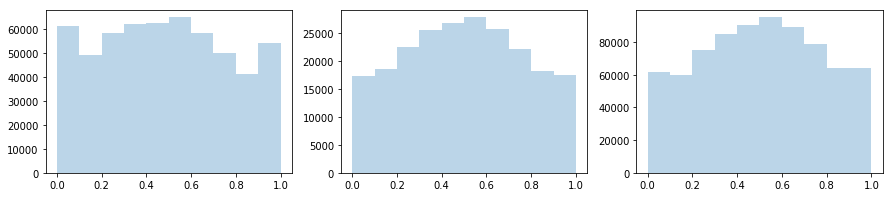

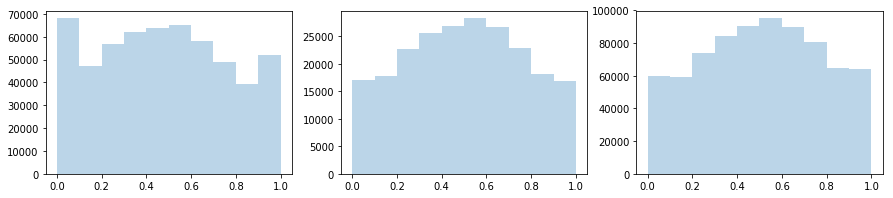

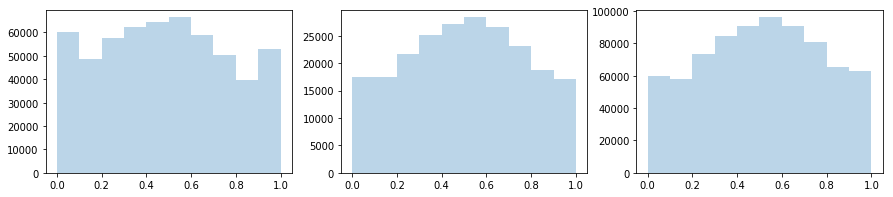

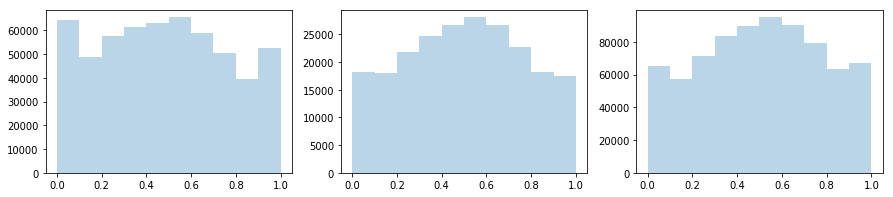

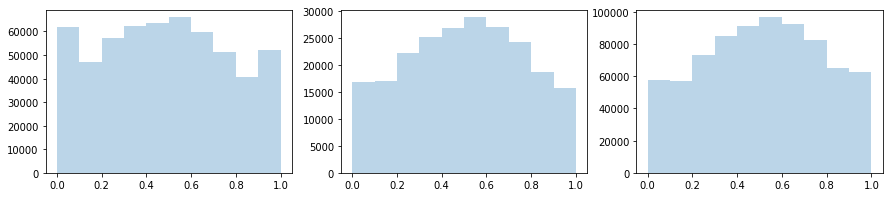

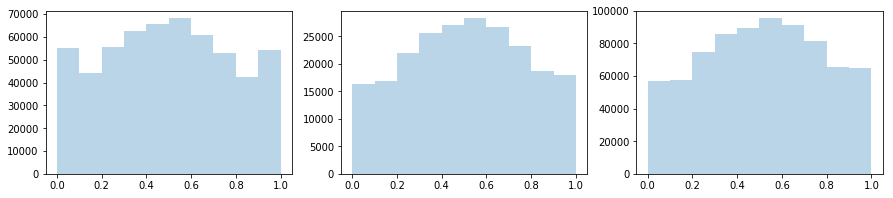

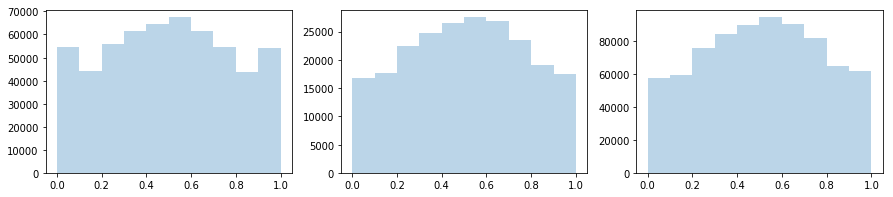

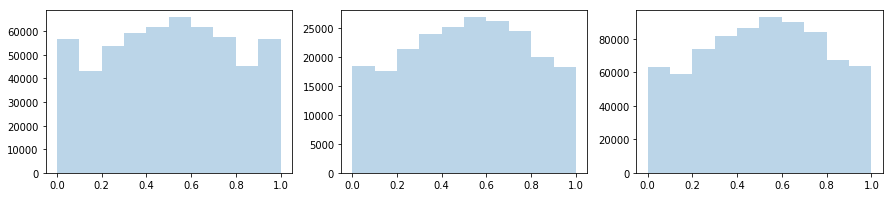

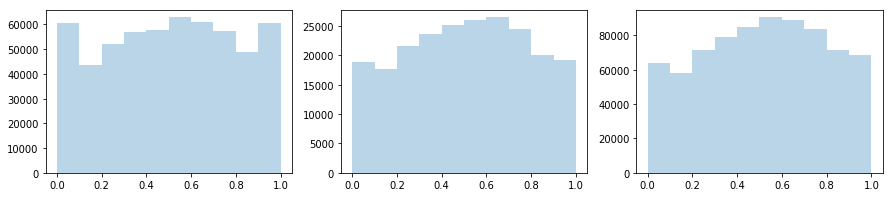

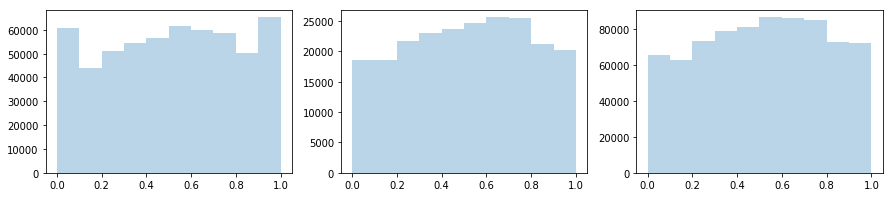

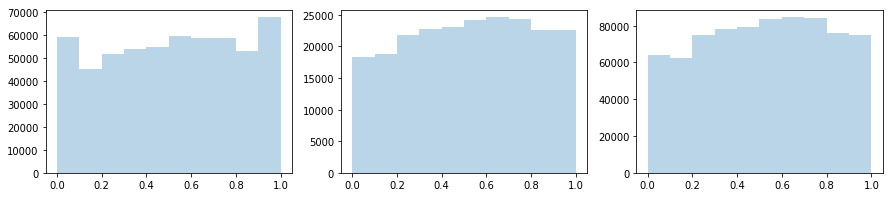

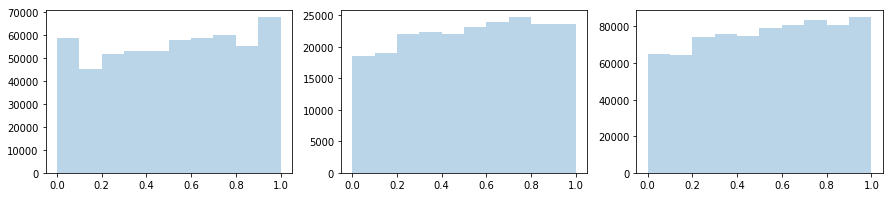

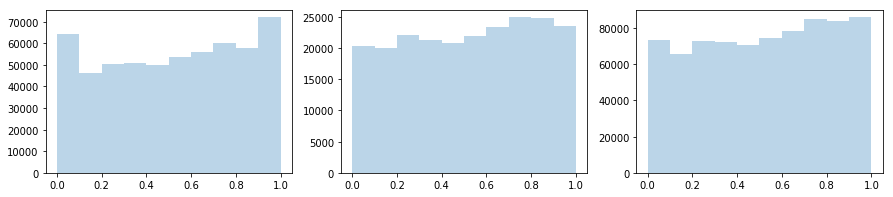

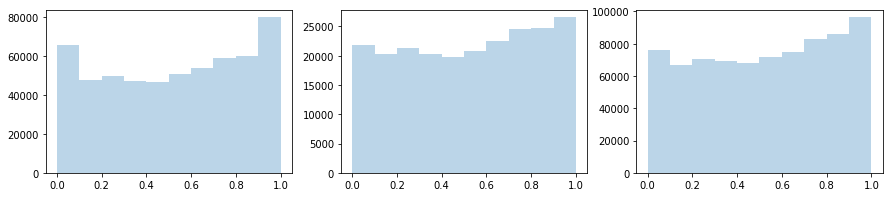

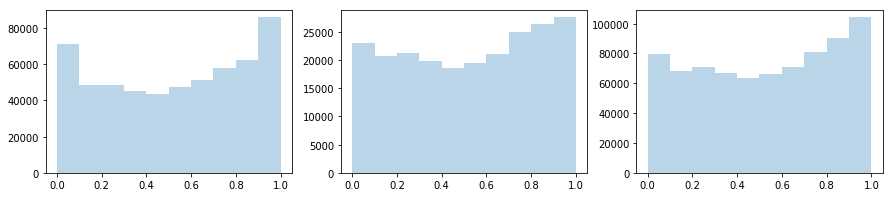

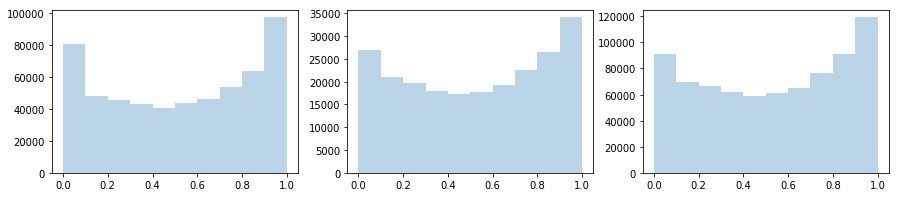

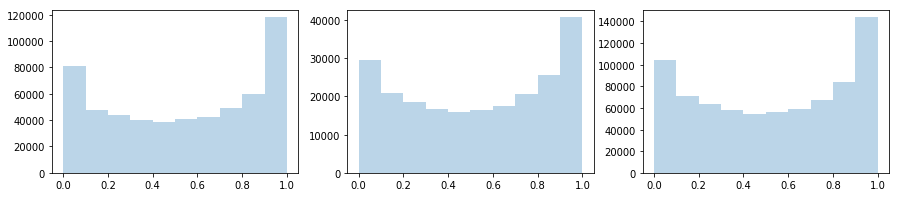

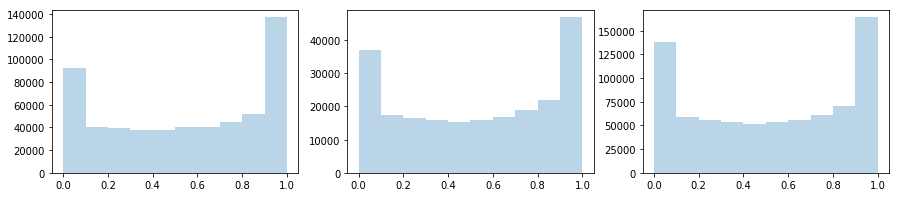

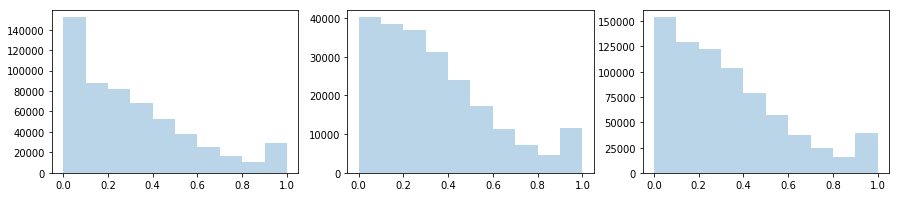

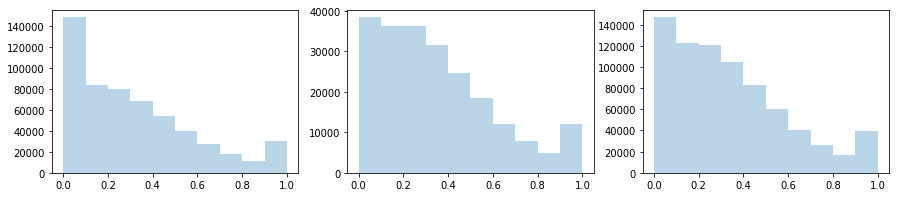

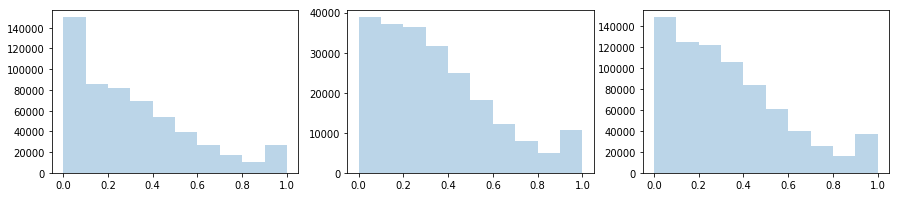

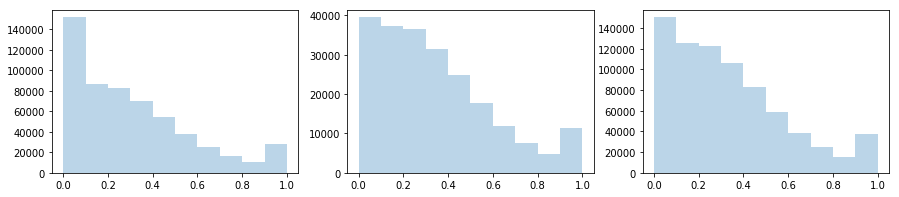

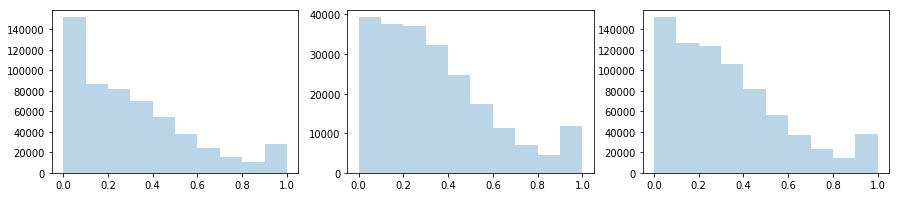

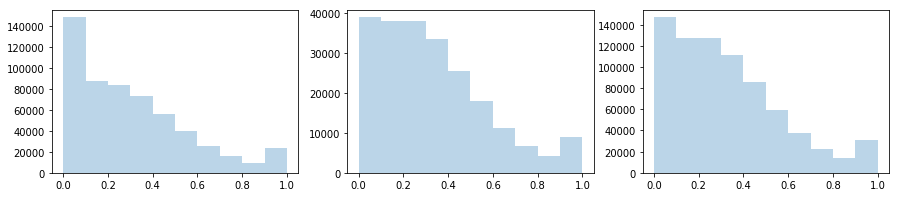

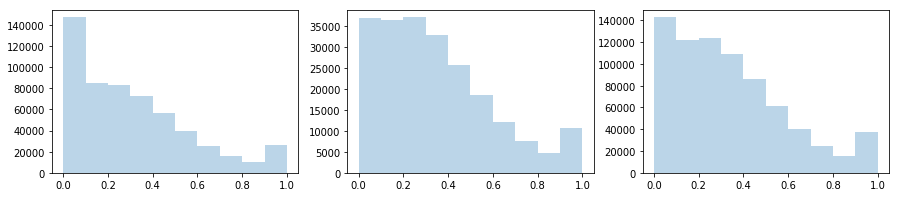

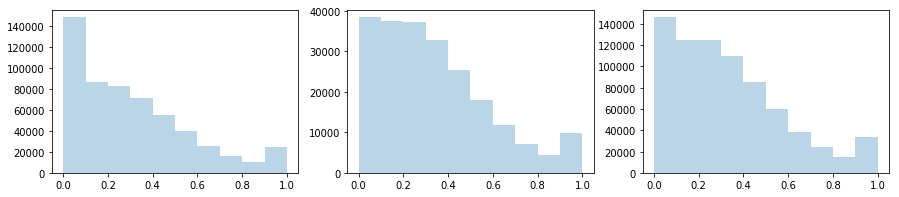

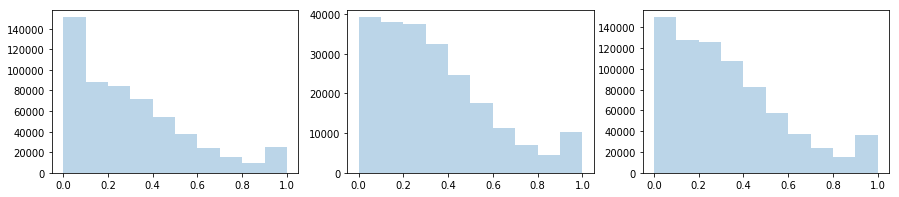

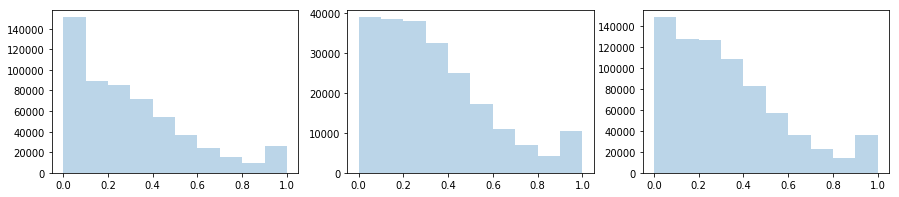

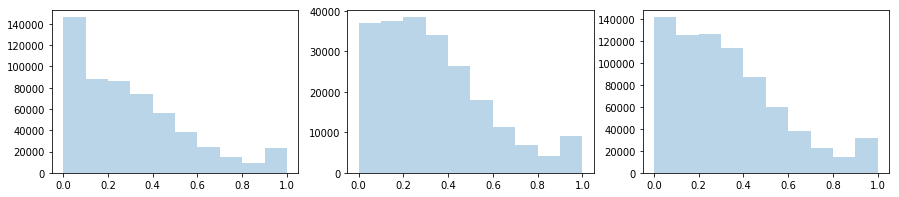

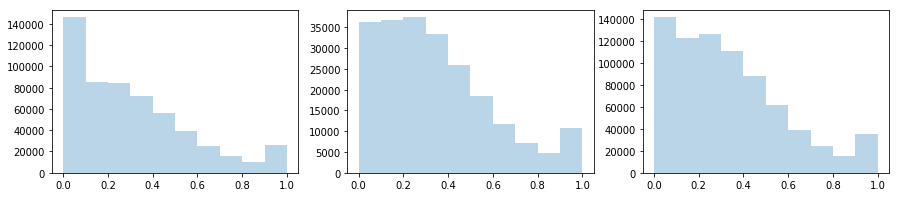

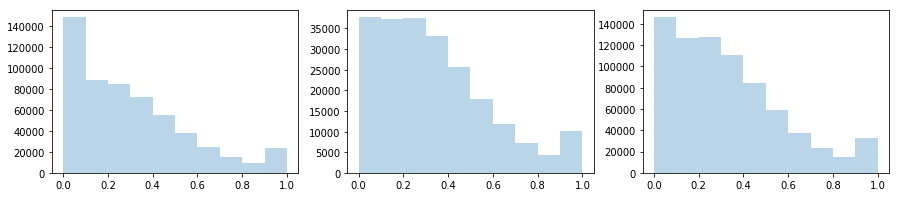

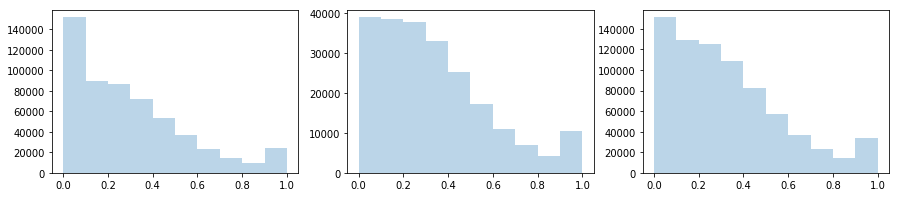

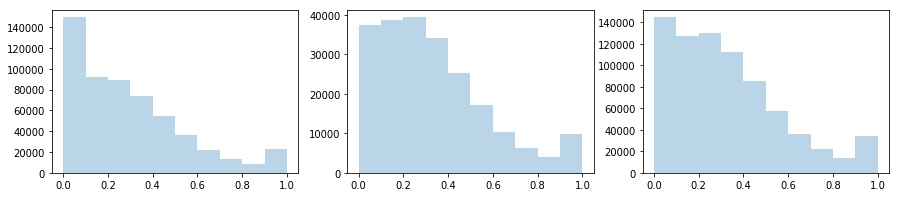

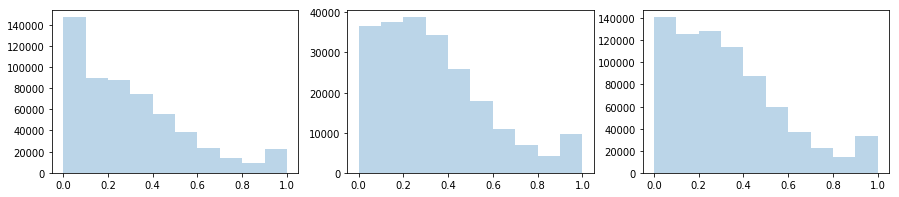

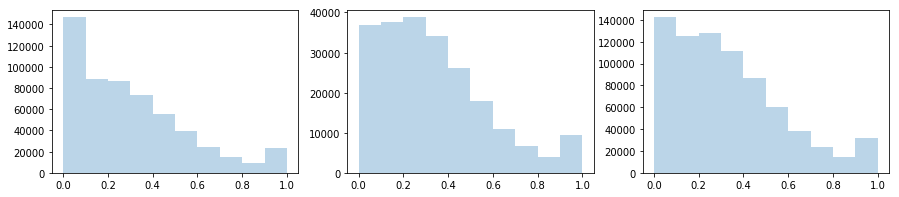

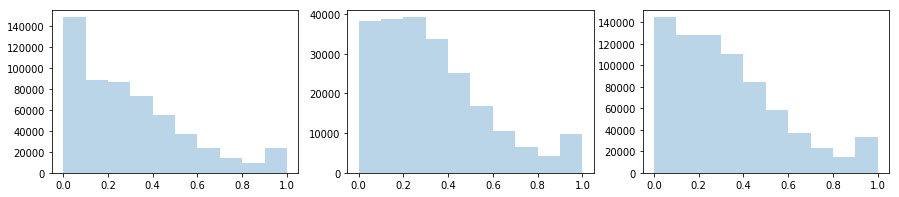

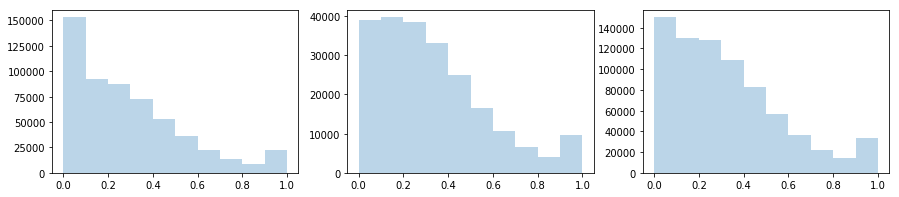

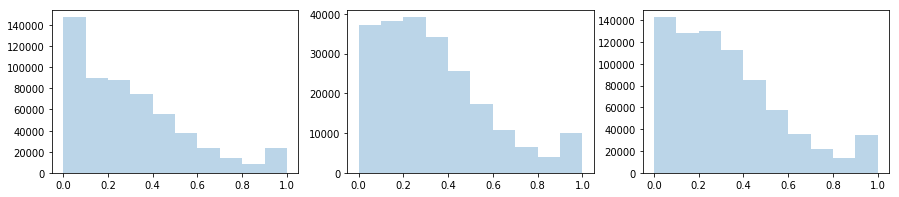

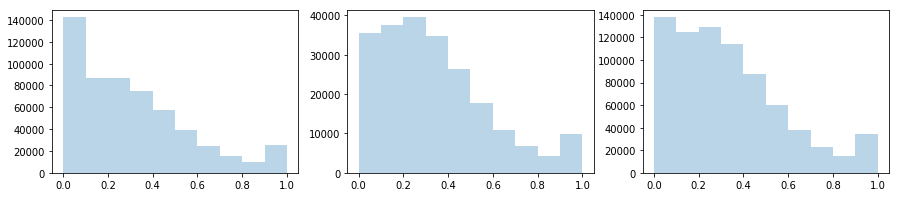

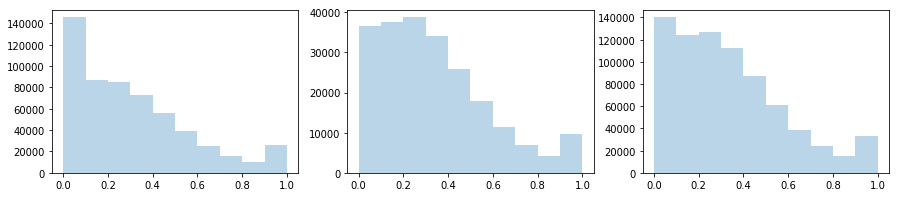

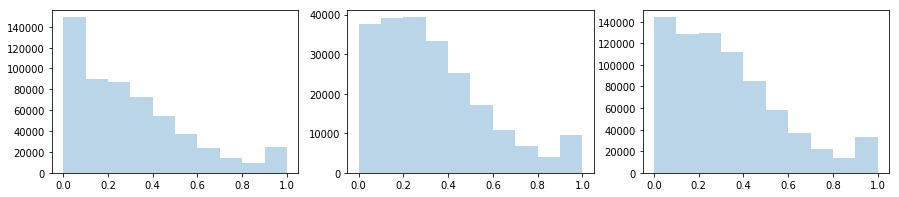

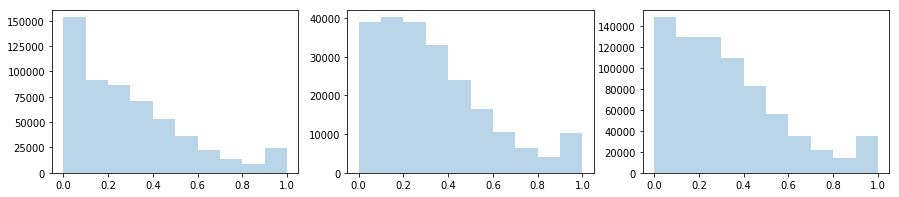

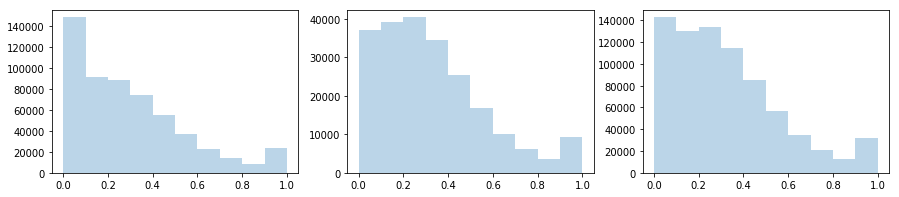

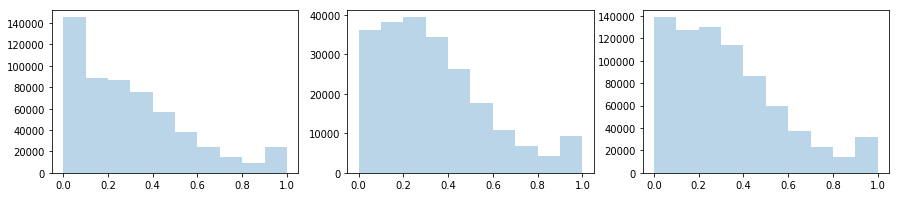

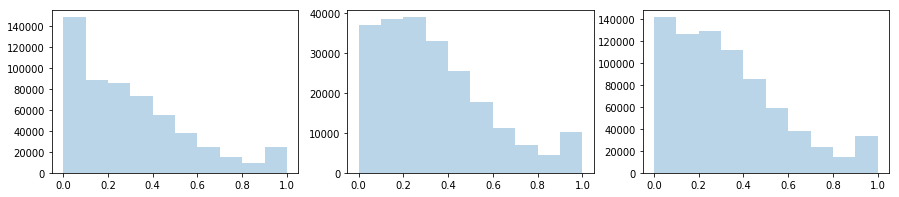

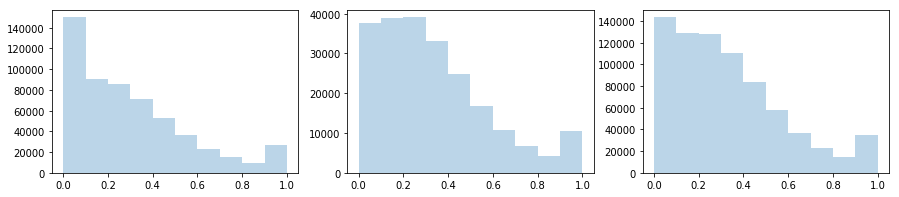

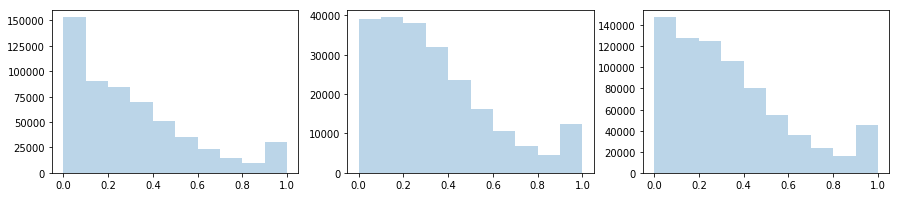

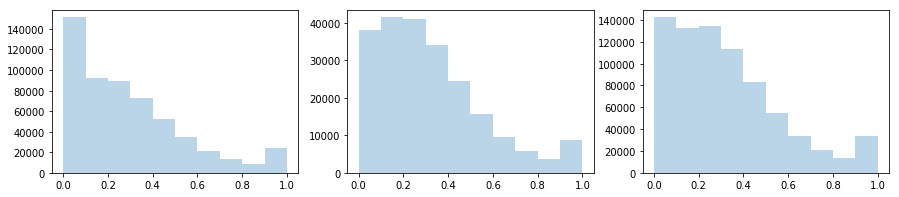

In [84]:
for i in range(0,60):
#     plt.figure()
    fig,ax=plt.subplots(1,3,figsize=(15,3))
    ax[0].hist(X[Y1[:,0]==1,i],alpha=0.3,label='0')
    ax[1].hist(X[Y1[:,1]==1,i],alpha=0.3,label='1')
    ax[2].hist(X[Y1[:,2]==1,i],alpha=0.3,label='2')
    
    plt.show()